# Markov Switching Vector Autoregressions
This tutorial shows how to simulate an MSVAR model and calculate its conditional and unconditional moments as in Bianchi (2016, JoE).

In [183]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import block_diag
import statsmodels.api as sm
import pandas as pd

sns.set(style = "white", font = "serif", context = "paper")

## Parametrizing a Simple Example
I consider a very simple 2-dimensional 2-state MSVAR(2,2) of the following form: 

$$Y_t = \mu_{s_t}+ A_{s_t} Y_{t-1} + \Sigma_{s_t} \varepsilon_t, \qquad \varepsilon_t \sim_{iid} \mathcal{N}(0,1),  $$
<br>
where $s_t$ is discrete first-order homogenous Markov chain with transition probabilities $P$ defined as follows:

$$P_{ij} = \text{Pr}[s_{t+1} = j|s_t = i], \qquad i,j \in \{1,2\} $$<br>
I first define the parameters of the model. Parameters are chosen ad-hoc but consistent with daily frequency data. 

In [131]:
# SETUP PARAMETERS

# number of state variables
N = 2

# number of Markov states
K = 2

# basis vectors
e = np.eye(N)

# autoregressive matrix (N x N x K) - state 2 is more persistent
AMat = np.zeros((N,N,K))
AMat[:,:,0] = np.diag(np.array([0.496, 0.92]))
AMat[:,:,1] = np.diag(np.array([0.496, 0.92])**0.9)

# state dependent means (N x K) - state 1 has a larger mean
muYMat = np.zeros((N,K))
muYMat[:,0] = 1.5 * np.array([0.0125,0.085]).T
muYMat[:,1] = 1 * np.array([0.0125,0.085]).T

# volatility of idiosyncratic shocks - state 2 is more volatile
SigMat = np.zeros((N,N,K))
SigMat[:,:,0] = np.diag(np.array([0.001, 0.02]))
SigMat[:,:,1] = np.diag(2*np.array([0.001, 0.02]))

# transition matrix
P = np.zeros((K,K))

# Regime 1 transition probabilities (normal times)
nDuration = 5*252
P[0,0] = 1 - 1 / nDuration
P[0,1] = 1 - P[0,0]

# Regime 2 transition probabilities (crisis times)
crisisDuration = 2*252
P[1,1] = 1 - 1 / crisisDuration
P[1,0] = 1 - P[1,1]

**Remark.** Notice that state 2 is more persistent and volatile and state 1 has a larger mean. Suppose the state variables represent economic quantities such as discount rates and dividend growth, then state 2 might be interpreted as a "crisis" state. 

### Calculating the Stationary Distribution of the Markov Chain
The stationary distribution of a Markov chain $\pi$ satisfies $P\pi = \pi$ and $\pi \mathbf{i} = 1$, where $i$ is a unit column vector. The vector $\pi$ is the normalized eigenvector of $P$ corresponding to eigenvalue $\lambda = 1$.

In [15]:
vals,vecs = LA.eig(P.T)
piVec = np.abs(vecs[:,np.argmax(np.abs(vals))])
piVec = piVec / piVec.sum()

## Simulation
I now simulate the process, plot results, and calculate simulated moments. 

In [150]:
def sim_msvar(AMat, SigMat, muYMat, P, piVec, N = 2, K = 2, TSample = 252*20, B = 1, rand_seed = 1):
    """
    Function to simulate MSVAR(N,K) with parameters (A,SigMat,muYMat,P,piVec) for B 
    bootstrap iterations of sample length TSample in days.
    """
    
    # Bianchi (2016) expactations: refer to JoE paper eq (1) - (6)
    w = np.tile(np.eye(N),(1,K))
    Omega = AMat[:,:,0]
    C = muYMat[:,[0]]
    for k in np.arange(1,K,1):
        Omega = block_diag(Omega, AMat[:,:,k])
        C = block_diag(C, muYMat[:,[k]])
    Omega = Omega @ (np.kron(P.T, np.eye(N)))
    muErgTest = w @ (LA.solve((np.eye(N*K) - Omega),C) @ piVec) * 252
    OmegaTilde = np.vstack((np.hstack((Omega, C @ P.T)),
                            np.hstack((np.zeros((K,N*K)),P.T))))
    wTilde = np.hstack((w, np.zeros((N,K))))
    qMatMean = np.nan * np.ones((N,K))
    for k in np.arange(0,K):
        qMatMean[:,[k]] = LA.solve((np.eye(N) - AMat[:,:,k]), muYMat[:,[k]])
        
    # main loop
    
    # for reproducability
    np.random.seed(rand_seed)
    
    # number of daily observations to simulate
    T = (TSample + 1) * B 
    
    # preallocate
        # markov states
    sSim = np.vstack((np.random.choice(K,p = piVec),
                     np.nan*np.ones((T,1))))
        # Y vector
    YSim = np.hstack((qMatMean[:,[int(sSim[0])]], np.nan * np.ones((N,T))))
        # shocks
    epsSim = np.nan * np.ones(YSim.shape)
        
    # simulate idiosyncratic shocks
    eSim = np.nan * np.ones((N,K,T+1))
    for ii in range(K):
        eSim[:,ii,:] = np.random.multivariate_normal(mean = np.zeros((N,)),
                                                     cov = SigMat[:,:,ii]**2,
                                                     size = (T+1,)).T
        
    # main loop
    for t in range(T+1):
        
        if t < T: 
            
            sSim[t+1] = np.random.choice(K, p = P[int(sSim[t]),:])
            epsSim[:,[t+1]] = eSim[:,[int(sSim[t+1])],t+1]
            YSim[:,[t+1]] = muYMat[:,[int(sSim[t+1])]] + AMat[:,:,[int(sSim[t+1])]].squeeze() @ YSim[:,[t]] + epsSim[:,[t+1]]# eSim[:,[int(sSim[t+1])],t+1]
    
   
    return YSim, sSim, epsSim

### Visualize the Process
I plot the simulated MSVAR below.

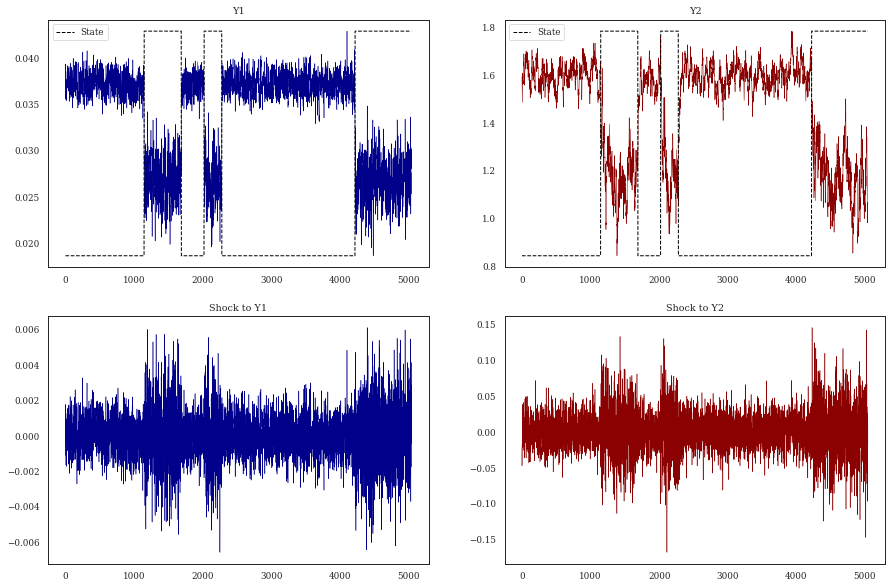

In [174]:
YSim, sSim, epsSim = sim_msvar(AMat, SigMat, muYMat, P, piVec, N = 2, K = 2, TSample = 252*20, B = 1, rand_seed = 1)

f, ax = plt.subplots(2,2,figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(YSim[0,:], linewidth = .5, color = "darkblue")
plt.plot(sSim * (YSim[0,:].max()-YSim[0,:].min()) + YSim[0,:].min() , 
         linewidth = 1, color = "black", linestyle = "dashed", label = "State")
plt.legend()
plt.title("Y1")
plt.subplot(2,2,2)
plt.plot(YSim[1,:], linewidth = .5, color = "darkred")
plt.plot(sSim * (YSim[1,:].max()-YSim[1,:].min()) + YSim[1,:].min() , 
         linewidth = 1, color = "black", linestyle = "dashed", label = "State")
plt.legend()
plt.title("Y2")
plt.subplot(2,2,3)
plt.plot(epsSim[0,:], linewidth = .5, label = "shock to Y1", color = "darkblue")
plt.title("Shock to Y1")
plt.subplot(2,2,4)
plt.plot(epsSim[1,:], linewidth = .5, label = "shock to Y2", color = "darkred")
plt.title("Shock to Y2")
plt.show()


### Simulated Moments
I calculate some simulated (unconditional) moments of interest.

In [185]:
ac1 = []; ac2 = []; var1 = []; var2 = []; mean1 = []; mean2 = [];

nSims =  100

for jj in range(nSims):
    YSim, _, _ = sim_msvar(AMat, SigMat, muYMat, P, piVec, N = 2, K = 2, TSample = 252*20, B = 1, rand_seed = jj)
    Y1 = YSim[0,:]
    Y2 = YSim[1,:]
    ac1.append(sm.tsa.acf(Y1, nlags = 2)[1])
    ac2.append(sm.tsa.acf(Y2, nlags = 2)[1])
    var1.append(np.nanstd(Y1)**2)
    var2.append(np.nanstd(Y2)**2)
    mean1.append(np.nanmean(Y1))
    mean2.append(np.nanmean(Y2))
    if jj % 10 == 0:
        print(f'{jj} / {nSims}')
    
Moments = ["AC1(Y1)", "AC1(Y2)", "VAR(Y1)", "VAR(Y2)", "MEAN(Y1)", "MEAN(Y2)"]
Means   = [np.mean(ac1), np.mean(ac2), np.mean(var1), np.mean(var2), np.mean(mean1), np.mean(mean2)]
StdErrs = [np.std(ac1), np.std(ac2), np.std(var1), np.std(var2), np.std(mean1), np.std(mean2)]

pd.DataFrame({"Moments": Moments, "Simulated Mean": Means, "Simulation Error": StdErrs })

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


,Moments,Simulated Mean,Simulation Error
0,AC1(Y1),0.931051,0.053817
1,AC1(Y2),0.986292,0.008656
2,VAR(Y1),0.000021,0.000008
3,VAR(Y2),0.032960,0.012313
4,MEAN(Y1),0.034390,0.001736
5,MEAN(Y2),1.482496,0.069342


## Analytic Moments
I compute the moments of the MSVAR a la Bianchi (2016) and then compare them to the simulated values. 

In [193]:
# conditional variance covariance matrix
# note: vec(VarY) = (I - kron(A,A))^{-1} * vec(SS')
A1 = AMat[:,:,0].squeeze()
A2 = AMat[:,:,1].squeeze()
S1 = SigMat[:,:,0].squeeze() @ SigMat[:,:,0].squeeze().T
S2 = SigMat[:,:,1].squeeze() @ SigMat[:,:,1].squeeze().T
VarY1 = (LA.solve((np.eye(N*N) - np.kron(A1,A1)), S1.flatten())).reshape((N,N)) 
VarY2 = (LA.solve((np.eye(N*N) - np.kron(A2,A2)), S2.flatten())).reshape((N,N)) 

# predefine useful selection vectors
S1 = e[:,[0]]
S2 = e[:,[1]]

# variance and standard deviation in state 1
var_y1_s1 = S1.T @ VarY1 @ S1
var_y2_s1 = S1.T @ VarY2 @ S1

# variance and standard deviation in state 2
var_y1_s2 = S2.T @ VarY1 @ S2
var_y2_s2 = S2.T @ VarY2 @ S2

# conditional covariance of state variables
cov_y1_y2_s1 = S1.T @ VarY1 @ S2
cov_y1_y2_s2 = S1.T @ VarY2 @ S2

# conditional correlation of state variables
corr_y1_y2_s1 = cov_y1_y2_s1 / (np.sqrt(var_y1_s1) * np.sqrt(var_y2_s1))
corr_y1_y2_s2 = cov_y1_y2_s2 / (np.sqrt(var_y1_s1) * np.sqrt(var_y2_s2))

In [332]:
# unconditional variance covariance moments - Bianchi (2016)
H = P.T # eq. (4)

C = block_diag(muYMat[:,[0]], muYMat[:,[1]])
Omega = block_diag(AMat[:,:,0].squeeze(), AMat[:,:,1].squeeze()) @ np.kron(H,np.eye(N))
q = LA.solve((np.eye(N*K) - Omega), (C @ piVec.reshape((N,1)))) # eq. (3)
OmegaTilde = np.vstack((np.hstack((Omega, C @ H)),
                       np.hstack((np.zeros((K,N*K)), H)))) # eq. (5)

w = np.tile(np.eye(N), (1,K))
mu = w @ q
mu2 = mu @ mu.T

wtilde = np.hstack((w, np.zeros((N,K))))
qtilde = np.vstack((q, piVec.reshape((N,1))))
mutp1 = wtilde @ OmegaTilde @ qtilde

c1 = muYMat[:,[0]]
c2 = muYMat[:,[1]]
cc1 = np.kron(c1,c1)
cc2 = np.kron(c2,c2)
V1 = SigMat[:,:,0]
V2 = SigMat[:,:,1]
VV1 = np.kron(V1,V1)
VV2 = np.kron(V2,V2)
A1 = AMat[:,:,0].squeeze()
A2 = AMat[:,:,1].squeeze()
AA1 = np.kron(A1,A1)
AA2 = np.kron(A2,A2)
DAC1 = np.kron(A1,c1) + np.kron(c1,A1)
DAC2 = np.kron(A2,c2) + np.kron(c2,A2)
Ik = np.eye(N)

Xi = block_diag(AA1,AA2) @ np.kron(H,np.eye(N**2))
VV = block_diag(np.expand_dims(VV1 @ Ik.flatten(),1), np.expand_dims(VV2 @ Ik.flatten(),1))
DAC = block_diag(DAC1, DAC2) @ np.kron(H, np.eye(N))
cc = block_diag(cc1,cc2)
Vc = VV + cc

Q = LA.solve((np.eye(2*N**2) - Xi), 
             (DAC @ np.expand_dims(q.flatten(),1) + Vc @ np.expand_dims(piVec,1))) # eq. (7)
W = np.tile(np.eye(N*N),(1,K))
M = W @ Q

vecVar = M - np.expand_dims(mu2.flatten(),1)

# unconditional variance-covariance matrix
VarY = vecVar.reshape((N,N))

# unconditional variance 
VarY1 = S1.T @ VarY @ S1
VarY2 = S2.T @ VarY @ S2

# unconditional autocorrelation
# see proposition 3 from Bianchi
IA1 = np.kron(np.eye(N),A1)
IA2 = np.kron(np.eye(N),A2)
Ic1 = np.kron(np.eye(N),c1)
Ic2 = np.kron(np.eye(N),c2)
Xil1 = block_diag(IA1,IA2) @ np.kron(H, np.eye(N*N))
Ic = block_diag(Ic1, Ic2)
Xiltilde = np.vstack((np.hstack((Xil1, Ic @ np.kron(H,np.eye(N)))),
                     np.hstack((np.zeros((N*2, N*4)), np.kron(H,np.eye(N))))))
Qttp1 = Xiltilde @ np.vstack((np.expand_dims(Q,1),np.expand_dims(q,1))).flatten() # eq. (13)

# first order AC matrix
AC1 = (Qttp1[:(N**2)] + Qttp1[N*2:N*4]).reshape((N,N)) - (mutp1 @ np.expand_dims(mu,1).T)
Acorr1 = AC1 / np.sqrt(np.diag(VarY).reshape((2,1)) @ np.diag(VarY).T.reshape((1,2)))

# unconditional first-order autocorrelation
AC1_y1 = S1.T @ Acorr1 @ S1
AC1_y2 = S2.T @ Acorr1 @ S2

## Checking Calculations
I compare the analytic and simulated moments. 

In [333]:
simMoments = [float(AC1_y1), float(AC1_y2), float(VarY1), float(VarY2), float(mu[0]), float(mu[1])]
pd.DataFrame({"Moments": Moments, "Simulated Mean": Means, "Simulation Error": StdErrs,
             "Simulated Moments": simMoments, "t-stat" : (np.array(simMoments)- np.array(Means)) / np.array(StdErrs)})



,Moments,Simulated Mean,Simulation Error,Simulated Moments,t-stat
0,AC1(Y1),0.931051,0.053817,0.950089,0.353752
1,AC1(Y2),0.986292,0.008656,0.990142,0.444795
2,VAR(Y1),0.000021,0.000008,0.000025,0.494806
3,VAR(Y2),0.032960,0.012313,0.039537,0.534116
4,MEAN(Y1),0.034390,0.001736,0.034206,-0.106263
5,MEAN(Y2),1.482496,0.069342,1.474615,-0.113657
